## LSTM の概要

LSTM = Long short-term memory  
以前やってた RNN の一種だけど、記憶のやり方が異なる。

以下のようなセルとゲートがあり、それぞれのゲートに学習パラメータを持ってる。

* 記憶セル : 過去の記憶を保持する
* 忘却ゲート : 過去の記憶を消す割合を調整する
* 入力ゲート : 新しい記憶を追加する割合を調整する
* 出力ゲート : 記憶セルの内容を出力に反する割合を調整する

加えて記憶セル → 積の間の Tanh も学習パラメータがあるので、学習パラメータが計4か所もあるという…

## 忘却ゲート

忘却ゲートはこんな感じ

$$
A^{(t)}_0 = \sigma ( X^{(t)} W_0 + Y^{(t-1)} V_0 + B_0 )
$$

- $A^{(t)}_0$ は活性関数後の値。  
- $\sigma$ はシグモイド関数。  
- $X^{(t)}$ は現時点の入力。
- $Y^{(t-1)}$ は前回の結果出力。

W,Bは重みとバイアス。

入力ゲートと新しい記憶データの $Tanh$ はこんな感じになる

## 入力ゲート

$$
A^{(t)}_1 = \sigma ( X^{(t)} W_1 + Y^{(t-1)} V_1 + B_1 )
$$

まぁ内容は見たままやね。

## 新しい記憶データは

$$
A^{(t)}_2 = tanh ( X^{(t)} W_2 + Y^{(t-1)} V_2 + B_2 )
$$

こいつらって結構見たままなのよね

## 出力ゲート

$$
A^{(t)}_3 = \sigma ( X^{(t)} W_3 + Y^{(t-1)} V_3 + B_3 )
$$

というか活性関数通す連中だから基本楽ですよね。


## LSTM 層の順伝播

$$
U^{(t)}_g = X^{(t)} W_g + Y^{(t-1)} V_g + B_g \\
A^{(t)}_g = f_g (U^{(t)}_g) \\
C^{(t)} = A^{(t)}_0 \circ C^{(t-1)} + A^{(t)}_1 \circ A^{(t)}_2 \\
Y^{(t)} = A^{(t)}_3 \circ tanh(C^{(t)})
$$

$g=0$ = 忘却ゲート、1=入力ゲート、2=新しい記憶、3=出力ゲート。 $f$ は $0,1,3$ の時シグモイドで 2 のとき $tanh$ 。  
X = 入力、W = 重み、B = バイアス、Y = 出力、V = 過去出力に対する重み。


## 逆伝播

各種勾配はこれを計算する必要があり

- 入力にかかる重み勾配 $\frac{\partial E}{\partial W_g}$
- 前の出力にかける勾配 $\frac{\partial E}{\partial V_g}$
- バイアス勾配 $\frac{\partial E}{\partial B_g}$

各時刻でも以下の勾配を計算する。

- 入力の勾配 $\frac{\partial E}{\partial X^{(t)}}$
- 前の時刻の出力の勾配 $\frac{\partial E}{\partial Y^{(t-1)}}$
- 前の時刻の記憶セルの勾配 $\frac{\partial E}{\partial C^{(t-1)}}$

この微分を始めるとして

$$
u^{(t)}_g = \sum^t_{k=1} x^{(t)}_k w_{g,k} + \sum^m_{k=1} y^{(t-1)}_k v_{g,k} + b_g \\
a^{(t)}_g = f_g (u^{(t)}_g) \\
c^{(t)} = a^{(t)}_0 c^{(t-1)} + a^{(t)}_1 a^{(t)}_2 \\
y^{(t)} = a^{(t)}_3 \circ tanh(c^{(t)})
$$

導出過程を端折ると

$$
\frac{\partial E}{\partial w_{g,i}} = \sum^{r}_{t=1} x^{(t)}_{i} \delta^{(t)}_{g} \\
\frac{\partial E}{\partial v_{g,i}} = \sum^{r}_{t=1} y^{(t-1)}_{i} \delta^{(t)}_{g} \\
\frac{\partial E}{\partial b_{g,i}} = \sum^{r}_{t=1} \delta^{(t)}_{g}
$$

前提式は

$$
\delta^{(t)}_g = \frac{\partial E}{\partial a^{(t)}_g} \frac{\partial a^{(t)}_g}{\partial u^{(t)}_g}
$$

先頭3件はこんな感じで、 後半3件はこんな感じ

$$
\frac{\partial E}{\partial X^{(t)}} = \sum^{3}_{g=0} \sum^{n}_{k=1} \frac{\partial E}{\partial u^{(t)}_{g,i}} \frac{\partial u^{(t)}_{g,k}}{\partial x^{(t)}_i} = \sum^{3}_{g=0} \sum^{n}_{k=1} w_{g,i} \delta^{(t)}_{g,k} \\
\frac{\partial E}{\partial y^{(t-1)}_i} = \sum^{3}_{g=0} \sum^{n}_{k=1} \frac{\partial E}{\partial u^{(t)}_{g,i}} \frac{\partial u^{(t)}_{g,k}}{\partial y^{(t)}_i} = \sum^{3}_{g=0} \sum^{n}_{k=1} v_{g,i} \delta^{(t)}_{g,k} \\
\frac{\partial E}{\partial c^{(t-1)}_i} = r^{(t)}a^{(t)}_0
$$


前提式は

$$
r^{(t)} = (\frac{\partial E}{\partial c^{(t)}} + \frac{\partial E}{\partial y^{(t)}} a_3 (1 - tanh^{2}(c^{(t)})))
$$

忘却ゲートは

$$
\delta^{(t)}_0 = r^{(t)} c^{(t-1)} a^{(t)}_0 (a - a^{(t)}_0)
$$

入力ゲート

$$
\delta^{(t)}_1 = r^{(t)} a^{(t)}_2 a^{(t)}_1 (1 - a^{(t)}_1)
$$

新しい記憶

$$
\delta^{(t)}_2 = r^{(t)} a^{(t)}_1 (1 - a^{(t)2}_2)
$$

出力ゲート

$$
\delta^{(t)}_3 = \frac{\partial E}{\partial y^{(t)}} tanh(c^{(t)}) a^{(t)}_3 (1 - a^{(t)}_3)
$$

Epoch:1/101 Error:5.2148607536980895


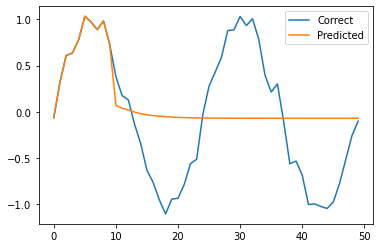

Epoch:11/101 Error:1.9179519861846444


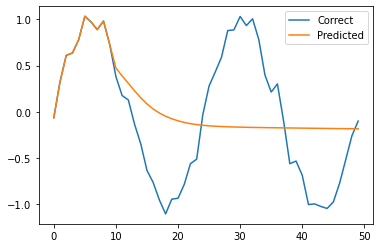

Epoch:21/101 Error:0.9623157137893104


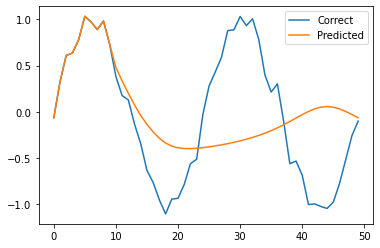

Epoch:31/101 Error:0.5216649669608928


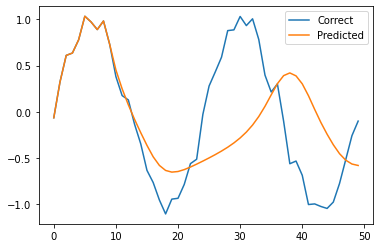

Epoch:41/101 Error:0.3727422278743423


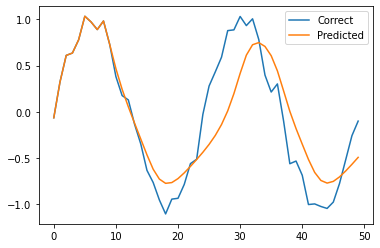

Epoch:51/101 Error:0.3225846844764183


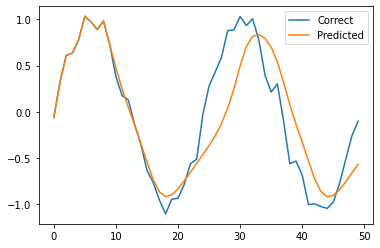

Epoch:61/101 Error:0.2986417906194491


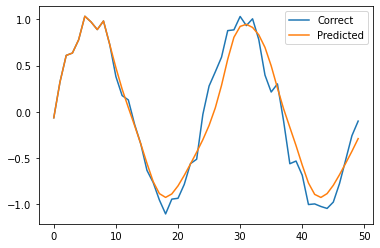

Epoch:71/101 Error:0.2832235791800767


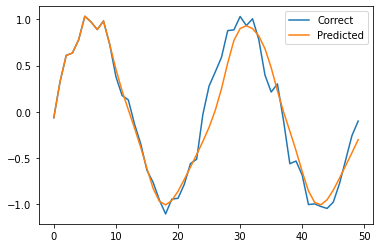

Epoch:81/101 Error:0.2722567779258378


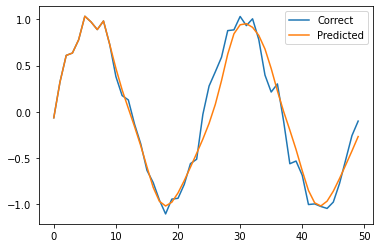

Epoch:91/101 Error:0.2650628636223391


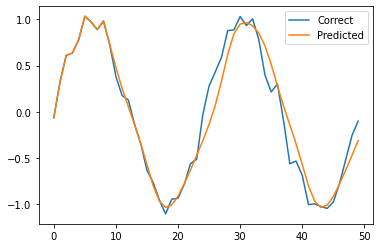

Epoch:101/101 Error:0.257668293285643


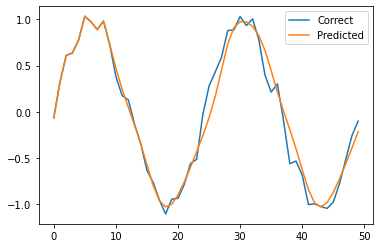

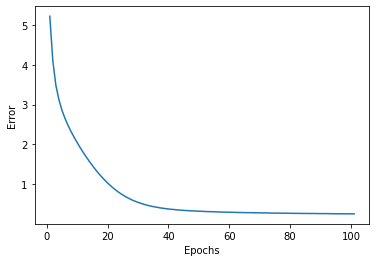

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n_time = 10  # 時系列の数
n_in = 1     # 入力層のニューロン数
n_mid = 30   # 中間層のニューロン数
n_out = 1    # 出力層のニューロン数

eta = 0.01     # 学習係数
epochs = 101   # 学習データの学習回数
batch_size = 8 # 1回の学習の処理数
interval = 10  # 経過の表示間隔

def sigmoid(x):
    return 1/(1+np.exp(-x))

# 訓練データの作成
# -2πから2πまでの波線作成
sin_x = np.linspace(-2*np.pi, 2*np.pi)
# 波線にノイズを加える
sin_y = np.sin(sin_x)  + 0.1*np.random.randn(len(sin_x))
# サンプル数
n_sample = len(sin_x)-n_time
# 入力
input_data = np.zeros((n_sample, n_time, n_in))
# 正解データ
correct_data = np.zeros((n_sample, n_out))
for i in range(0, n_sample):
    input_data[i] = sin_y[i : i+n_time].reshape(-1, 1)
    # 正解は入力よりも一つ後
    correct_data[i] = sin_y[i+n_time : i+n_time+1]

# LSTM層 
class LSTMLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n_upper)  # Xavierの初期値
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))

    def forward(self, x, y_prev, c_prev):
        # y_prev, c_prev: 前の時刻の出力と記憶セル
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)

        a0 = sigmoid(u[0])  # 忘却ゲート
        a1 = sigmoid(u[1])  # 入力ゲート
        a2 = np.tanh(u[2])  # 新しい記憶
        a3 = sigmoid(u[3])  # 出力ゲート
        self.gates = np.stack((a0, a1, a2, a3))
        self.c = a0 * c_prev + a1 * a2 # 記憶セル
        self.y = a3 * np.tanh(self.c)  # 出力
    
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):   
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + (grad_y*a3) * (1-tanh_c**2)

        # 各delta値
        delta_a0 = r * c_prev * a0 * (1-a0)
        delta_a1 = r * a2 * a1 * (1-a1)
        delta_a2 = r * a1 * (1 - a2**2)
        delta_a3 = grad_y * tanh_c * a3 * (1 - a3)

        deltas = np.stack((delta_a0, delta_a1, delta_a2, delta_a3))

        # 各パラメータの勾配
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)

        # x
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)

        # y_prev
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        # c_prevの勾配
        self.grad_c_prev = r * a0

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

# 全結合 出力層
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavierの初期値
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 恒等関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# 各層の初期化
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# 訓練
def train(x_mb, t_mb):
    # 順伝播 LSTM層
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)

        y = lstm_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        c = lstm_layer.c
        c_rnn[:, i+1, :] = c
        c_prev = c

        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 順伝播 出力層
    output_layer.forward(y)

    # 逆伝播 出力層
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)

    # 逆伝播 LSTM層
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        c = c_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev

    # パラメータの更新
    lstm_layer.update(eta)
    output_layer.update(eta)

# 予測
def predict(x_mb):
    # 順伝播 LSTM層
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c

    # 順伝播 出力層
    output_layer.forward(y)
    return output_layer.y

# 誤差を計算
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 二乗和誤差

error_record = []
n_batch = len(input_data) // batch_size  # 1エポックあたりのバッチ数
for i in range(epochs):
        
    # 学習 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    # 誤差を求める
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # 経過の表示 
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 最初の入力
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # 出力をpredictedに追加する

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()